# Ciencia de Datos acelerada con GPUs: Puntualidad en tráfico aéreo durante COVID

Cuando la pandemia inició, muchas industrias se vieron obligadas a disminuir y hasta cerrar operaciones. Un ejemplo, es la insdustria aérea, que sufrió una disminución significativa en los vuelos. Esto habrá tenido algún impacto en su performance de puntualidad? los vuelos son más puntuales?

Fuentes:
1. [Open Flights Data](https://openflights.org/data.html)
2. [Bureau of Transportation Statistics](https://www.transtats.bts.gov/DL_SelectFields.asp?Table_ID=236&DB_Short_Name=On-Time). Vamos a usar data del periodo de 1/01/2020 a 31/05/2020.

jupyter labextension install @jupyter-widgets/jupyterlab-manager

## Imports
Primero lo primero, vamos a importar las herramientas que necesitaremos.

In [1]:
import cudf
import blazingsql as bsql
import s3fs
import numpy as np
from collections import OrderedDict
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

### `BlazingContext`
Es necesario que establezcas a BlazingContext para conectarte a la instancia BlazingSQL, y así crear tablas, ejecutar consultas y básicamente, hacer cualquier cosa con BlazingSQL.

In [2]:
bc = bsql.BlazingContext()

BlazingContext ready


## Ingerir y ejecutar data

Hay dos maneras para cargar y ejecutar data usando las herramientas del ecosistema de RAPIDS: cargar directamente a la memoria usando `cudf` o `.create_table()` usando `BlazingContext`.

### Data de vuelos
Rutas a archivos

In [3]:
flight_data_path = 's3://bsql/data/air_transport/flight_ontime_2020-0[1-5].parquet'
s3 = s3fs.S3FileSystem(anon=True)
files = [f's3://{f}' for f in s3.glob(flight_data_path)]
files

['s3://bsql/data/air_transport/flight_ontime_2020-01.parquet',
 's3://bsql/data/air_transport/flight_ontime_2020-02.parquet',
 's3://bsql/data/air_transport/flight_ontime_2020-03.parquet',
 's3://bsql/data/air_transport/flight_ontime_2020-04.parquet',
 's3://bsql/data/air_transport/flight_ontime_2020-05.parquet']

#### Leyendo la data
Usaremos cuDF.

In [4]:
%%time
flights = []

for f in files:
    flights.append(cudf.read_parquet(f, storage_options={'anon': True}))
    
flights = cudf.concat(flights)

CPU times: user 1.33 s, sys: 366 ms, total: 1.69 s
Wall time: 3.78 s


In [5]:
flights.head(5)

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,MKT_UNIQUE_CARRIER,MKT_CARRIER_FL_NUM,OP_UNIQUE_CARRIER,TAIL_NUM,...,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Unnamed: 54
0,2020,1,1,1,3,2020-01-01,WN,5888,WN,N951WN,...,95.0,122.0,74.0,363.0,8.0,0.0,27.0,0.0,33.0,<NA>
1,2020,1,1,1,3,2020-01-01,WN,6276,WN,N467WN,...,90.0,92.0,71.0,363.0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2,2020,1,1,1,3,2020-01-01,WN,4598,WN,N7885A,...,70.0,68.0,57.0,333.0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
3,2020,1,1,1,3,2020-01-01,WN,4761,WN,N551WN,...,75.0,75.0,63.0,333.0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
4,2020,1,1,1,3,2020-01-01,WN,5162,WN,N968WN,...,80.0,67.0,57.0,333.0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


In [7]:
print(f'Número total de vuelos en el dataset: {len(flights):,}')

Número total de vuelos en el dataset: 2,508,583


#### Registrando una tabla con `BlazingContext`

In [8]:
bc.create_table('flights', flights)

#### Columnas y tipo de data

In [9]:
flights.columns

Index(['YEAR', 'QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'FL_DATE',
       'MKT_UNIQUE_CARRIER', 'MKT_CARRIER_FL_NUM', 'OP_UNIQUE_CARRIER',
       'TAIL_NUM', 'OP_CARRIER_FL_NUM', 'ORIGIN_AIRPORT_ID',
       'ORIGIN_AIRPORT_SEQ_ID', 'ORIGIN_CITY_MARKET_ID', 'ORIGIN',
       'ORIGIN_STATE_ABR', 'ORIGIN_WAC', 'DEST_AIRPORT_ID',
       'DEST_AIRPORT_SEQ_ID', 'DEST_CITY_MARKET_ID', 'DEST', 'DEST_STATE_ABR',
       'DEST_WAC', 'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'DEP_DELAY_NEW',
       'DEP_DEL15', 'DEP_DELAY_GROUP', 'DEP_TIME_BLK', 'TAXI_OUT',
       'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME',
       'ARR_DELAY', 'ARR_DELAY_NEW', 'ARR_DEL15', 'ARR_DELAY_GROUP',
       'ARR_TIME_BLK', 'CANCELLED', 'CANCELLATION_CODE', 'DIVERTED', 'DUP',
       'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'DISTANCE',
       'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY',
       'LATE_AIRCRAFT_DELAY', 'Unnamed: 54'],
      dtype='object')

In [10]:
flights.dtypes

YEAR                       int64
QUARTER                    int64
MONTH                      int64
DAY_OF_MONTH               int64
DAY_OF_WEEK                int64
FL_DATE                   object
MKT_UNIQUE_CARRIER        object
MKT_CARRIER_FL_NUM        object
OP_UNIQUE_CARRIER         object
TAIL_NUM                  object
OP_CARRIER_FL_NUM         object
ORIGIN_AIRPORT_ID          int64
ORIGIN_AIRPORT_SEQ_ID      int64
ORIGIN_CITY_MARKET_ID      int64
ORIGIN                    object
ORIGIN_STATE_ABR          object
ORIGIN_WAC                 int64
DEST_AIRPORT_ID            int64
DEST_AIRPORT_SEQ_ID        int64
DEST_CITY_MARKET_ID        int64
DEST                      object
DEST_STATE_ABR            object
DEST_WAC                   int64
CRS_DEP_TIME              object
DEP_TIME                  object
DEP_DELAY                float64
DEP_DELAY_NEW            float64
DEP_DEL15                float64
DEP_DELAY_GROUP          float64
DEP_TIME_BLK              object
TAXI_OUT  

### Data de vuelos y aeropuertos
Paths to files

In [11]:
airports_path = 's3://bsql/data/air_transport/airports.csv'
airlines_path = 's3://bsql/data/air_transport/airlines.csv'

#### Leyendo la data

In [12]:
airports_dtypes = OrderedDict([
      ('Airport ID', 'int64')
    , ('Name', 'str')
    , ('City', 'str')
    , ('Country', 'str')
    , ('IATA', 'str')
    , ('ICAO', 'str')
    , ('Latitude', 'float64')
    , ('Longitude', 'float64')
    , ('Altitude', 'int64')
    , ('Timezone', 'str')
    , ('DST', 'str')
    , ('Type', 'str')
    , ('Source', 'str')
])

airports = cudf.read_csv(
    airports_path
    , names=list(airports_dtypes.keys())
    , dtype=list(airports_dtypes.values())
    , storage_options={'anon': True}
)
airports.head()

,Airport ID,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude,Timezone,DST,Type,Source
0,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,5282,10,U,Pacific/Port_Moresby,airport
1,2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789001,20,10,U,Pacific/Port_Moresby,airport
2,3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296005,5388,10,U,Pacific/Port_Moresby,airport
3,4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,239,10,U,Pacific/Port_Moresby,airport
4,5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380,147.220001,146,10,U,Pacific/Port_Moresby,airport


In [13]:
airlines_dtypes = OrderedDict([
    ('Airline ID', 'int64')
    , ('Name', 'str')
    , ('Alias', 'str')
    , ('IATA', 'str')
    , ('ICAO', 'str')
    , ('Callsign', 'str')
    , ('Country', 'str')
    , ('Active', 'str')
])

airlines = cudf.read_csv(
    airlines_path
    , names=list(airlines_dtypes.keys())
    , dtype=list(airlines_dtypes.values())
    , storage_options={'anon': True}
)
airlines.head()

,Airline ID,Name,Alias,IATA,ICAO,Callsign,Country,Active
0,-1,Unknown,\N,-,N/A,\N,\N,Y
1,1,Private flight,\N,-,N/A,,,Y
2,2,135 Airways,\N,,GNL,GENERAL,United States,N
3,3,1Time Airline,\N,1T,RNX,NEXTIME,South Africa,Y
4,4,2 Sqn No 1 Elementary Flying Training School,\N,,WYT,,United Kingdom,N


Register tables with `BlazingContext`

In [14]:
bc.create_table('airports', airports)
bc.create_table('airlines', airlines)

Añadir state a la tabla `airports`.

In [15]:
airports_geo = bc.sql('''
    SELECT DISTINCT A.airport
        , A.State
        , B.Name
        , B.City
    FROM (
        SELECT DISTINCT ORIGIN AS Airport
            , ORIGIN_STATE_ABR AS State
        FROM flights

        UNION ALL
        SELECT DISTINCT DEST AS Airport
            , DEST_STATE_ABR AS State
        FROM flights AS A
    ) AS A
    LEFT OUTER JOIN airports AS B
        ON A.Airport = B.IATA
''')
bc.create_table('airports_geo', airports_geo)

In [16]:
%%time
bc.sql('''
    SELECT A.FL_DATE
        , A.OP_UNIQUE_CARRIER
        , B.Name AS CARRIER_NAME
        , A.ORIGIN
        , C.Name AS ORIGIN_NAME
        , C.City AS ORIGIN_CITY
        , C.State AS ORIGIN_STATE        
        , A.DEST
        , D.Name AS DEST_NAME
        , D.City AS DEST_CITY
        , A.DEP_DELAY AS Delay
    FROM flights AS A
    LEFT OUTER JOIN airlines AS B
        ON A.OP_UNIQUE_CARRIER = B.IATA
    LEFT OUTER JOIN airports_geo AS C
        ON A.ORIGIN = C.airport
    LEFT OUTER JOIN airports_geo AS D
        ON A.DEST = D.airport
    LIMIT 4
''')

CPU times: user 577 ms, sys: 103 ms, total: 681 ms
Wall time: 469 ms


,FL_DATE,OP_UNIQUE_CARRIER,CARRIER_NAME,ORIGIN,ORIGIN_NAME,ORIGIN_CITY,ORIGIN_STATE,DEST,DEST_NAME,DEST_CITY,Delay
0,2020-01-27,OH,Comair,PHF,Newport News Williamsburg International Airport,Newport News,VA,CLT,Charlotte Douglas International Airport,Charlotte,-7.0
1,2020-01-28,OH,Comair,PHF,Newport News Williamsburg International Airport,Newport News,VA,CLT,Charlotte Douglas International Airport,Charlotte,34.0
2,2020-01-29,OH,Comair,PHF,Newport News Williamsburg International Airport,Newport News,VA,CLT,Charlotte Douglas International Airport,Charlotte,-9.0
3,2020-01-30,OH,Comair,PHF,Newport News Williamsburg International Airport,Newport News,VA,CLT,Charlotte Douglas International Airport,Charlotte,-2.0


## Preguntas

### 1. Cuántos aeropuertos hay en el dataset?

In [17]:
print(f'Hay {len(flights["ORIGIN"].unique())} aeropuertos en el dataset')

Hay 371 aeropuertos en el dataset


### 2. Cuántos vuelos tuvieron retraso y cuántos partieron a tiempo? Cuál es la distribución?

In [19]:
print(f'{len(flights[flights["DEP_DELAY"] > 0]):,} vuelos con retraso y {len(flights[flights["DEP_DELAY"] <= 0]):,} vuelos a tiempo')

501,295 vuelos con retraso y 1,726,305 vuelos a tiempo


In [20]:
### calculando la distribución
n_bins = 100

delays = flights[flights['DEP_DELAY'] >  0]['DEP_DELAY']
ontime = flights[flights['DEP_DELAY'] <= 0]['DEP_DELAY']

CPU times: user 172 ms, sys: 3.63 ms, total: 176 ms
Wall time: 174 ms


<AxesSubplot:title={'center':'Distribución de salidas con demora'}>

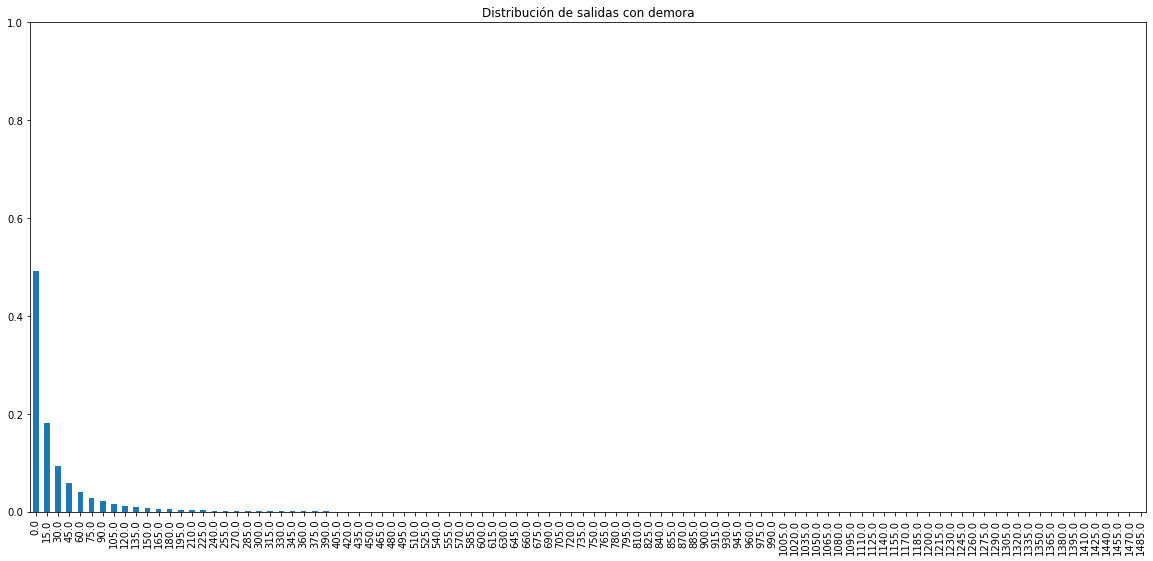

In [22]:
%%time
del_bins = np.array([i * 15 for i in range(0, n_bins)], dtype='float64')
delays_binned = delays.digitize(del_bins)
delays_histogram = delays_binned.groupby().count() / len(delays)
(
    delays_histogram
    .set_index(del_bins[delays_histogram.index.to_array()-1])
    .to_pandas()
    .plot(kind='bar', figsize=(20,9), ylim=[0,1.0], title='Distribución de salidas con demora')
)

CPU times: user 137 ms, sys: 0 ns, total: 137 ms
Wall time: 135 ms


<AxesSubplot:title={'center':'Distribución de salidas a tiempo'}>

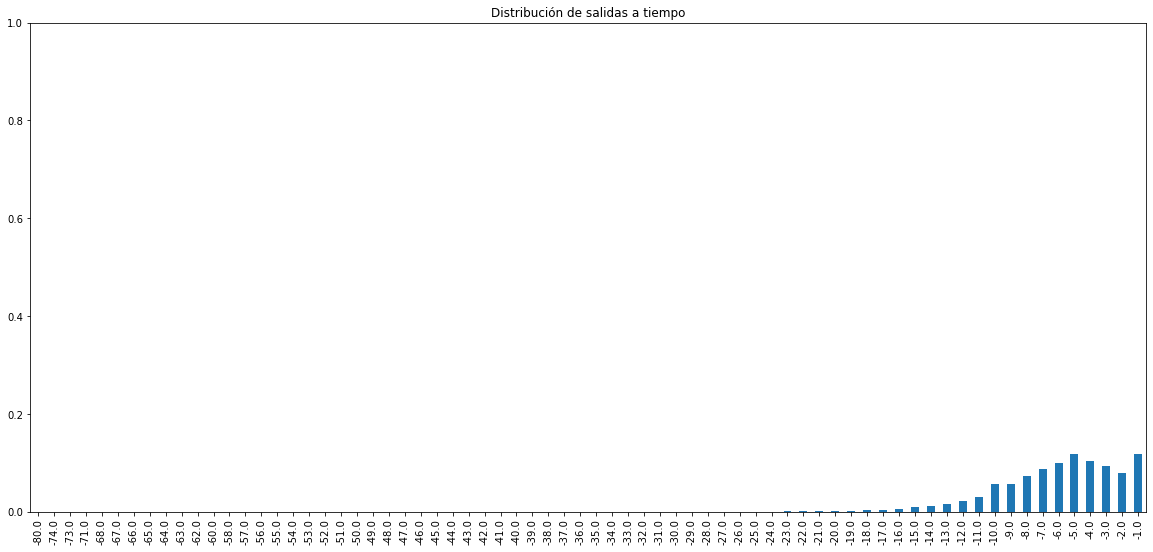

In [23]:
%%time
ontime_bins = np.array([i * (-1) for i in range(n_bins,0,-1)], dtype='float64')
ontime_binned = ontime.digitize(ontime_bins)
ontime_histogram = ontime_binned.groupby().count() / len(ontime)
(
    ontime_histogram
    .set_index(ontime_bins[ontime_histogram.index.to_array()-1])
    .to_pandas()
    .plot(kind='bar', figsize=(20,9), ylim=[0,1.0], title='Distribución de salidas a tiempo')
)

### 3. Distribución de demora a través del tiempo

In [24]:
q10 = lambda x: x.quantile(0.10); q10.__name__ = "q0.10"
q25 = lambda x: x.quantile(0.25); q25.__name__ = "q0.25"
q75 = lambda x: x.quantile(0.75); q75.__name__ = "q0.75"
q90 = lambda x: x.quantile(0.90); q90.__name__ = "q0.90"

delay_aggs = (
    flights[['MONTH', 'DEP_DELAY']]
    .groupby(by='MONTH')
    .agg({'DEP_DELAY': [q10, q25,'median',q75, q90]})
)

delay_aggs.columns = ['_'.join(col) for col in delay_aggs.columns]

In [25]:
host=delay_aggs.to_pandas()
host

,DEP_DELAY_q0.10,DEP_DELAY_q0.25,DEP_DELAY_median,DEP_DELAY_q0.75,DEP_DELAY_q0.90
MONTH,,,,,
1,-9.0,-6.0,-3.0,2.0,25.0
2,-9.0,-6.0,-3.0,2.0,28.0
3,-11.0,-8.0,-5.0,-1.0,13.0
4,-13.0,-10.0,-6.0,-4.0,0.0
5,-10.0,-8.0,-5.0,-2.0,2.0


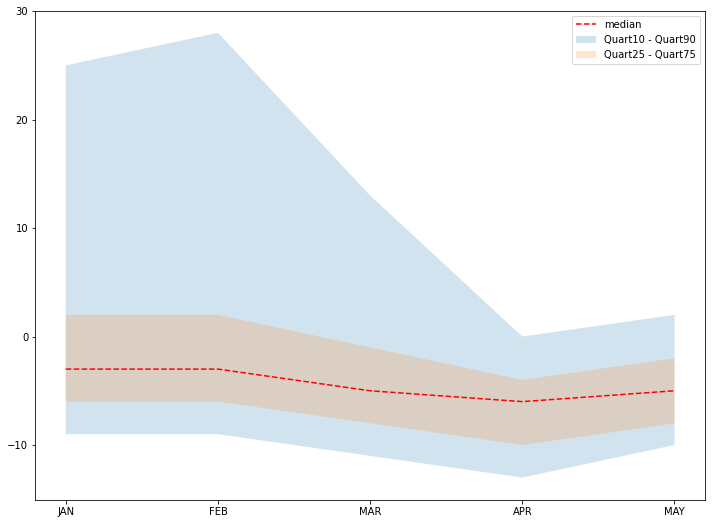

In [26]:
x = ['JAN', 'FEB', 'MAR', 'APR', 'MAY']
fig, ax = plt.subplots(figsize=(12,9))
ax.plot(x, host['DEP_DELAY_median'], 'r--', label='median')
ax.fill_between(x, host['DEP_DELAY_q0.10'], host['DEP_DELAY_q0.90']
                , alpha=.2, label='Quart10 - Quart90')
ax.fill_between(x, host['DEP_DELAY_q0.25'], host['DEP_DELAY_q0.75']
                , alpha=.2, label='Quart25 - Quart75')
ax.legend()

### 4. Cuáles son las top 5 aerolíneas y aeropuertos con mayores retrasos y al menos 1000 vuelos? Cuál es el promedio de demora?

In [27]:
delays = flights[flights['DEP_DELAY'] >  0][['DEP_DELAY', 'ORIGIN', 'DEST', 'OP_UNIQUE_CARRIER']]
ontime = flights[flights['DEP_DELAY'] <= 0][['DEP_DELAY', 'ORIGIN', 'DEST', 'OP_UNIQUE_CARRIER']]

In [28]:
bc.create_table('delays', delays)
bc.create_table('ontime', ontime)

In [29]:
def plot_airports(df, cmap, agg_cols, indicator):
    host = df.to_pandas()
    
    ### figure
    fig = plt.figure(figsize=(12,9))
    
    ### plot on map
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
    ax.set_extent([-125, -70, 22, 55], crs=ccrs.PlateCarree()) ## US Continental
    ax.stock_img()
    
    ### add features
    ax.add_feature(cfeature.LAKES)
    ax.add_feature(cfeature.STATES)
    ax.add_feature(cfeature.COASTLINE)
    
    ### add data
    bubbles = ax.scatter(
        host['Longitude']
        , host['Latitude']
        , s=host[agg_cols['CNT']] / 50, label="Flight Count"
        , c=host[agg_cols['AVG']]
        , cmap=plt.get_cmap(cmap)
        , alpha=0.8
    )

    ### add colorbar
    delays = host[agg_cols['AVG']]
    tick_values = np.linspace(delays.min(), delays.max(), 11)
    cbar = fig.colorbar(bubbles, shrink=0.7)
    cbar.ax.set_yticklabels([f'{round(v)} mins' for v in tick_values], fontsize=14)
    cbar.set_label(f'Average {indicator}', fontsize=16)
    plt.legend(fontsize=16)

### Mayores retrasos
#### Origen

In [30]:
%%time
delayed_origin = bc.sql('''
    SELECT A.ORIGIN
        , B.Name AS ORIGIN_Airport
        , B.City AS ORIGIN_City
        , B.Country AS ORIGIN_Country
        , B.Latitude
        , B.Longitude
        , COUNT(*) AS DELAY_CNT
        , AVG(DEP_DELAY) AS AVG_DELAY
    FROM delays AS A
    LEFT OUTER JOIN airports AS B
        ON A.ORIGIN = B.IATA
    GROUP BY A.ORIGIN
        , B.Name
        , B.City
        , B.Country
        , B.Latitude
        , B.Longitude
    HAVING COUNT(*) > 1000
        AND B.Country = 'United States'
    ORDER BY AVG(DEP_DELAY) DESC
    LIMIT 60
''')
delayed_origin.head()

CPU times: user 439 ms, sys: 27.2 ms, total: 466 ms
Wall time: 248 ms


,ORIGIN,ORIGIN_Airport,ORIGIN_City,ORIGIN_Country,Latitude,Longitude,DELAY_CNT,AVG_DELAY
0,ORF,Norfolk International Airport,Norfolk,United States,36.894600,-76.201202,1324,56.907100
1,SAV,Savannah Hilton Head International Airport,Savannah,United States,32.127602,-81.202103,1011,54.965381
2,CHS,Charleston Air Force Base-International Airport,Charleston,United States,32.898602,-80.040497,1281,52.105386
3,IAD,Washington Dulles International Airport,Washington,United States,38.944500,-77.455803,4450,51.613034
4,SDF,Louisville International Standiford Field,Louisville,United States,38.174400,-85.736000,1444,50.712604


<ipython-input-29-6193742958e0>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels([f'{round(v)} mins' for v in tick_values], fontsize=14)
/opt/conda-environments/rapids-stable/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:387: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  return matplotlib.axes.Axes.draw(self, renderer=renderer,
/opt/conda-environments/rapids-stable/lib/python3.8/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/110m/physical/ne_110m_lakes.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
/opt/conda-environments/rapids-stable/lib/python3.8/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: http://n

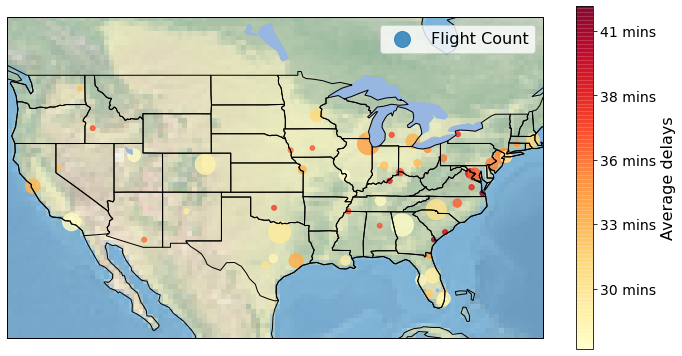

In [31]:
### plot
plot_airports(
    delayed_origin
    , 'YlOrRd'
    , {'CNT': 'DELAY_CNT', 'AVG': 'AVG_DELAY'}
    , 'delays'
)

#### Destino

In [32]:
%%time
delayed_destination = bc.sql('''
    SELECT A.DEST
        , B.Name AS DEST_Airport
        , B.City AS DEST_City
        , B.Country AS DEST_Country
        , B.Latitude
        , B.Longitude
        , COUNT(*) AS DELAY_CNT
        , AVG(DEP_DELAY) AS AVG_DELAY
    FROM delays AS A
    LEFT OUTER JOIN airports AS B
        ON A.DEST = B.IATA
    GROUP BY A.DEST
        , B.Name
        , B.City
        , B.Country
        , B.Latitude
        , B.Longitude
    HAVING COUNT(*) > 1000
        AND B.Country = 'United States'
    ORDER BY AVG(DEP_DELAY) DESC
    LIMIT 60
''')
delayed_destination.head()

CPU times: user 500 ms, sys: 15.7 ms, total: 516 ms
Wall time: 268 ms


,DEST,DEST_Airport,DEST_City,DEST_Country,Latitude,Longitude,DELAY_CNT,AVG_DELAY
0,ORD,Chicago O'Hare International Airport,Chicago,United States,41.978600,-87.904800,21263,55.751399
1,EWR,Newark Liberty International Airport,Newark,United States,40.692501,-74.168701,10813,50.394618
2,IAD,Washington Dulles International Airport,Washington,United States,38.944500,-77.455803,4521,49.702057
3,GSO,Piedmont Triad International Airport,Greensboro,United States,36.097801,-79.937302,1075,49.218605
4,TYS,McGhee Tyson Airport,Knoxville,United States,35.811001,-83.994003,1163,48.245916


<ipython-input-29-6193742958e0>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels([f'{round(v)} mins' for v in tick_values], fontsize=14)
/opt/conda-environments/rapids-stable/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:387: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  return matplotlib.axes.Axes.draw(self, renderer=renderer,


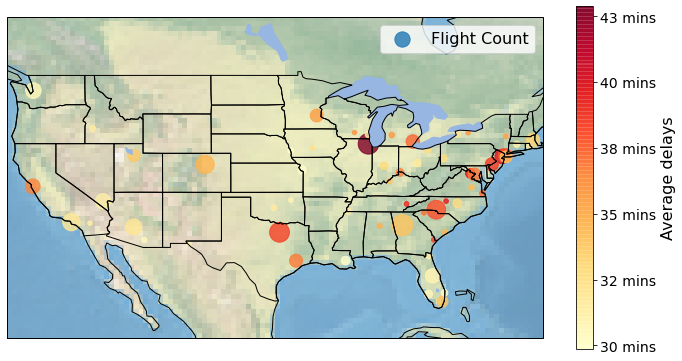

In [33]:
### plot
plot_airports(
    delayed_destination
    , 'YlOrRd'
    , {'CNT': 'DELAY_CNT', 'AVG': 'AVG_DELAY'}
    , 'delays'
)

#### Aerolíneas

In [34]:
%%time
bc.sql('''
    SELECT A.OP_UNIQUE_CARRIER AS CARRIER
        , B.Name AS CARRIER_Name
        , B.Country AS CARRIER_Country
        , COUNT(*) AS DELAY_CNT
        , AVG(DEP_DELAY) AS AVG_DELAY
    FROM delays AS A
    LEFT OUTER JOIN airlines AS B
        ON A.OP_UNIQUE_CARRIER = B.IATA
    GROUP BY A.OP_UNIQUE_CARRIER
        , B.Name
        , B.Country
    HAVING COUNT(*) > 1000
    ORDER BY AVG(DEP_DELAY) DESC
    LIMIT 5
''')

CPU times: user 178 ms, sys: 15.5 ms, total: 194 ms
Wall time: 133 ms


,CARRIER,CARRIER_Name,CARRIER_Country,DELAY_CNT,AVG_DELAY
0,C5,CommutAir,United States,3845,69.091547
1,ZW,Air Wisconsin,United States,5163,64.122797
2,AX,Trans States Airlines,United States,3759,62.545358
3,G7,GoJet Airlines,United States,3772,58.113203
4,G7,Gandalf Airlines,Italy,3772,58.113203


### Los más puntuales

#### Origen

In [35]:
%%time
ontime_origin = bc.sql('''
    SELECT A.ORIGIN
        , B.Name AS ORIGIN_Airport
        , B.City AS ORIGIN_City
        , B.Country AS ORIGIN_Country
        , B.Latitude
        , B.Longitude
        , COUNT(*) AS ONTIME_CNT
        , AVG(DEP_DELAY) AS AVG_ONTIME
    FROM ontime AS A
    LEFT OUTER JOIN airports AS B
        ON A.ORIGIN = B.IATA
    GROUP BY A.ORIGIN
        , B.Name
        , B.City
        , B.Country
        , B.Latitude
        , B.Longitude
    HAVING COUNT(*) > 1000
        AND B.Country = 'United States'
    ORDER BY AVG(DEP_DELAY) DESC
    LIMIT 60
''')
ontime_origin.head()

CPU times: user 264 ms, sys: 37.3 ms, total: 302 ms
Wall time: 237 ms


,ORIGIN,ORIGIN_Airport,ORIGIN_City,ORIGIN_Country,Latitude,Longitude,ONTIME_CNT,AVG_ONTIME
0,DAL,Dallas Love Field,Dallas,United States,32.847099,-96.851799,15470,-3.839302
1,HOU,William P Hobby Airport,Houston,United States,29.645399,-95.278900,11619,-3.892418
2,MDW,Chicago Midway International Airport,Chicago,United States,41.785999,-87.752403,14770,-3.956601
3,ATL,Hartsfield Jackson Atlanta International Airport,Atlanta,United States,33.636700,-84.428101,81666,-3.990277
4,MSP,Minneapolis-St Paul International/Wold-Chamber...,Minneapolis,United States,44.882000,-93.221802,34114,-4.447910


<ipython-input-29-6193742958e0>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels([f'{round(v)} mins' for v in tick_values], fontsize=14)
/opt/conda-environments/rapids-stable/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:387: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  return matplotlib.axes.Axes.draw(self, renderer=renderer,


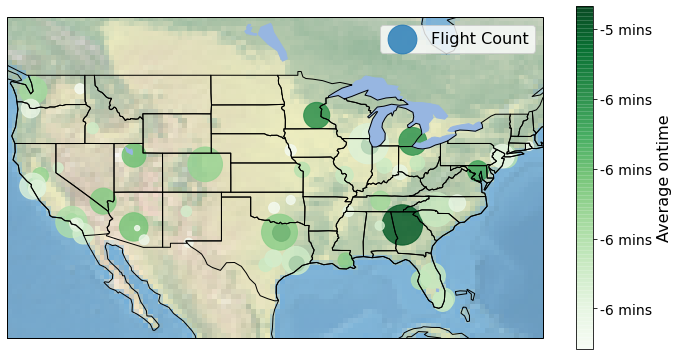

In [36]:
### plot
plot_airports(
    ontime_origin
    , 'Greens'
    , {'CNT': 'ONTIME_CNT', 'AVG': 'AVG_ONTIME'}
    , 'ontime'
)

#### Destino

In [37]:
%%time
ontime_destination = bc.sql('''
    SELECT A.DEST
        , B.Name AS DEST_Airport
        , B.City AS DEST_City
        , B.Country AS DEST_Country
        , B.Latitude
        , B.Longitude
        , COUNT(*) AS ONTIME_CNT
        , AVG(DEP_DELAY) AS AVG_ONTIME
    FROM ontime AS A
    LEFT OUTER JOIN airports AS B
        ON A.DEST = B.IATA
    GROUP BY A.DEST
        , B.Name
        , B.City
        , B.Country
        , B.Latitude
        , B.Longitude
    HAVING COUNT(*) > 1000
        AND B.Country = 'United States'
    ORDER BY AVG(DEP_DELAY) DESC
    LIMIT 30
''')
ontime_destination.head(5)

CPU times: user 439 ms, sys: 41 ms, total: 480 ms
Wall time: 351 ms


,DEST,DEST_Airport,DEST_City,DEST_Country,Latitude,Longitude,ONTIME_CNT,AVG_ONTIME
0,HOU,William P Hobby Airport,Houston,United States,29.645399,-95.278900,12608,-3.926237
1,MDW,Chicago Midway International Airport,Chicago,United States,41.785999,-87.752403,16535,-3.933595
2,DAL,Dallas Love Field,Dallas,United States,32.847099,-96.851799,16450,-3.979331
3,OAK,Metropolitan Oakland International Airport,Oakland,United States,37.721298,-122.221001,10336,-4.312210
4,BUR,Bob Hope Airport,Burbank,United States,34.200699,-118.359001,6903,-4.504563


<ipython-input-29-6193742958e0>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels([f'{round(v)} mins' for v in tick_values], fontsize=14)
/opt/conda-environments/rapids-stable/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:387: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  return matplotlib.axes.Axes.draw(self, renderer=renderer,


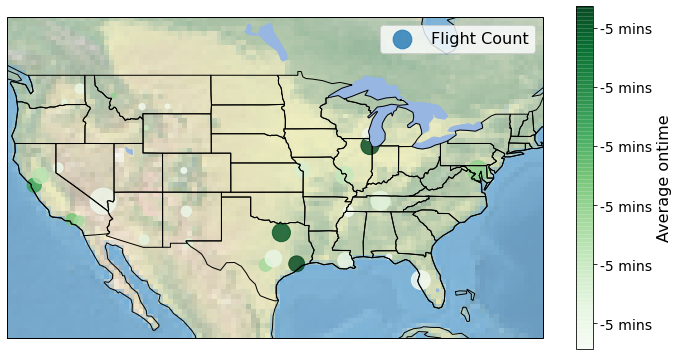

In [38]:
### plot
plot_airports(
    ontime_destination
    , 'Greens'
    , {'CNT': 'ONTIME_CNT', 'AVG': 'AVG_ONTIME'}
    , 'ontime'
)

#### Airline

In [39]:
%%time
bc.sql('''
    SELECT A.OP_UNIQUE_CARRIER AS CARRIER
        , B.Name AS CARRIER_Name
        , B.Country AS CARRIER_Country
        , AVG(DEP_DELAY) AS AVG_ONTIME
    FROM ontime AS A
    LEFT OUTER JOIN airlines AS B
        ON A.OP_UNIQUE_CARRIER = B.IATA
    GROUP BY A.OP_UNIQUE_CARRIER
        , B.Name
        , B.Country
    HAVING COUNT(*) > 1000
    ORDER BY AVG(DEP_DELAY) DESC
    LIMIT 5
''')

CPU times: user 299 ms, sys: 35.1 ms, total: 335 ms
Wall time: 295 ms


,CARRIER,CARRIER_Name,CARRIER_Country,AVG_ONTIME
0,WN,Southwest Airlines,United States,-3.984769
1,DL,Delta Air Lines,United States,-4.585165
2,NK,Spirit Airlines,United States,-5.292633
3,QX,Horizon Air,United States,-5.522188
4,AA,American Airlines,United States,-5.885033


### 5. Qué vuelos departing SEA experienced significant delays?

In [ ]:
%%time
destinations = bc.sql('''
    SELECT ORIGIN
        , ORIGIN_LAT
        , ORIGIN_LON
        , DEST
        , DEST_LAT
        , DEST_LON
        , COUNT(*) AS DELAY_CNT
        , AVG(Delay) AS AVG_DELAY
    FROM (
        SELECT A.ORIGIN
            , B.Latitude AS ORIGIN_LAT
            , B.Longitude AS ORIGIN_LON
            , A.DEST
            , C.Latitude AS DEST_LAT
            , C.Longitude AS DEST_LON
            , A.DEP_DELAY AS Delay
        FROM flights AS A
        LEFT OUTER JOIN airports AS B
            ON A.ORIGIN = B.IATA
        LEFT OUTER JOIN airports AS C
            ON A.DEST = C.IATA
        WHERE ORIGIN = 'SEA'
            AND C.Country = 'United States'
            AND DEP_DELAY > 60  -- DELAYED BY MORE THAN HOUR
    ) AS A
    GROUP BY ORIGIN
        , ORIGIN_LAT
        , ORIGIN_LON
        , DEST
        , DEST_LAT
        , DEST_LON
    HAVING COUNT(*) > 50
    ORDER BY AVG_DELAY DESC
    LIMIT 30
''')
destinations.head(5)

Plot the results on the map

In [ ]:
def add_lines(ax, host):
    lines = host[['ORIGIN_LON', 'ORIGIN_LAT', 'DEST_LON', 'DEST_LAT']].to_dict('list')
    
    sea = (lines['ORIGIN_LON'][0], lines['ORIGIN_LAT'][0])
    for dest in zip(lines['DEST_LON'], lines['DEST_LAT']):
        ax.arrow(*dest
                 , sea[0]-dest[0], sea[1]-dest[1]
                 , head_width=0.0, head_length=0.0
                 , fc='k', ec='k')

host = destinations.to_pandas()
    
### figure
fig = plt.figure(figsize=(12,9))

### plot on map
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([-125, -70, 22, 55], crs=ccrs.PlateCarree()) ## US Continental
ax.stock_img()

### add features
ax.add_feature(cfeature.LAKES)
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.COASTLINE)

### add data
bubbles = ax.scatter(
    host['DEST_LON']
    , host['DEST_LAT']
    , s=host['DELAY_CNT'] * 2, label="Flight Count"
    , c=host['AVG_DELAY']
    , cmap=plt.get_cmap('jet')
    , alpha=0.8
)

add_lines(ax, host)

### add colorbar
delays = host['AVG_DELAY']
tick_values = np.linspace(delays.min(), delays.max(), 11)
cbar = fig.colorbar(bubbles, shrink=0.7)
cbar.ax.set_yticklabels([f'{round(v)} mins' for v in tick_values], fontsize=14)
cbar.set_label(f'Average delays', fontsize=16)
plt.legend(fontsize=16)

### 6. Are there any specifc aircrafts (tail number) that are less reliable?

In [ ]:
tail_numbers = bc.sql('''
    SELECT TAIL_NUM
        , B.Name AS AirlineName
        , DEP_DELAY
    FROM flights AS A
    LEFT OUTER JOIN airlines AS B
        ON A.OP_UNIQUE_CARRIER = B.IATA
    WHERE TAIL_NUM <> ''
        AND DEP_DELAY > 0
''')

In [ ]:
aircraft_aggs = (
    tail_numbers
    .groupby(by=['TAIL_NUM', 'AirlineName'])
    .agg({'DEP_DELAY': ['count', q25,'median',q75, 'max']})
)

aircraft_aggs.columns = ['_'.join(col) for col in aircraft_aggs.columns]
aircraft_aggs = (
    aircraft_aggs
    .query('DEP_DELAY_count > 100')
    .sort_values(by='DEP_DELAY_median', ascending=False)
)

In [ ]:
aircraft_aggs.head(10)